## 3. data pre-processing and modelling
We will experiment different classification algorithms in this section, evaluate their performance and give a summary report.

Q1: Which algorithm is our best choice for this dataset?

Big data can be divided into two categories, the super long data or the super wide data. The wide data is also called high-dimensional data. Some algorithms are really good at handling such data set, for instance, support vector machine and naive bayes. Since our data set is long, we will not test these two algorithms in this experiment. Instead, we will try logistic regression, decision tree, random forest, gradient boosting, etc.

### 3.1 model development using df_new
#### 3.1.1 data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

In [2]:
file='data/df_new.csv'
df=pd.read_csv(file)

In [3]:
features_name=df.drop(columns=['DEFAULT', 'ID']).columns

In [4]:
features_name

Index(['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'MARRIAGE_2', 'MARRIAGE_3', 'SEX_2',
       'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4'],
      dtype='object')

In [5]:
from numpy import loadtxt
X_train_s = loadtxt('data/X1_train_s.csv', delimiter=',')
X_test_s = loadtxt('data/X1_test_s.csv', delimiter=',')
y_train = loadtxt('data/y1_train.csv', delimiter=',')
y_test = loadtxt('data/y1_test.csv', delimiter=',')

### 3.1.2 model development

#### 3.1.2.1 regularized logistic regression
Binary logistic regression is the simplest classification algorithms. But it cannot perform very well when there are colinearity between predictors. It is also vulnerable to overfitting. As we explored the correlation between predictors in section1, we found some colinearity between them. Hence, we decided to use regularized logistic regression and use GridSearchCV( ) to find the best value of the hyperparameter, [C](https://scikit-learn.org/0.15/modules/generated/sklearn.linear_model.LogisticRegression.html).

Because gridSearchCV is very time-consuming for some algorithms, here we choose RandomizedSearchCV.

In [6]:
start=time.time()
logreg = LogisticRegression()
param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]} # C is the inverse of regularization strength; must be a positive float. Smaller values of C mean stronger regularization.
logreg_cv = RandomizedSearchCV(logreg, param_grid , cv=5, random_state=42)
logreg_cv.fit(X_train_s,y_train)
end=time.time()
print("BEST PARAMS", logreg_cv.best_params_)
print(f"Runtime of the program is {end - start}")

BEST PARAMS {'C': 0.01}
Runtime of the program is 7.686629056930542


Text(0.5, 15.0, 'Predicted label')

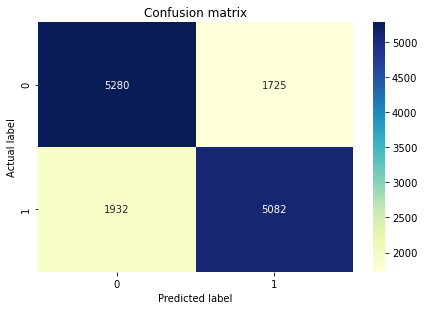

In [7]:
# use the best C value, 0.01, to develop regularized logistic regression model
best_C_logreg=logreg_cv.best_estimator_
y_pred=best_C_logreg.predict(X_test_s)
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [8]:
print("Accuracy:",accuracy_score(y_test, y_pred).round(3))
print("Precision:",precision_score(y_test, y_pred).round(3))
print("Recall:",recall_score(y_test, y_pred).round(3))

Accuracy: 0.739
Precision: 0.747
Recall: 0.725


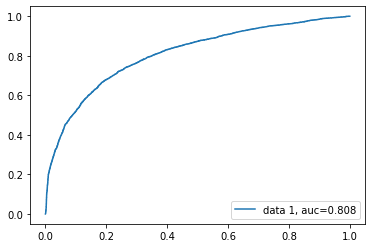

In [9]:
y_pred_proba = best_C_logreg.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(3)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

There are [three ways](https://towardsdatascience.com/a-look-into-feature-importance-in-logistic-regression-models-a4aa970f9b0f) to rank features in a Logistic Regression model. They are by coefficient values, recursive feature elimination (RFE) and sci-kit Learn’s SelectFromModels (SFM). Here, we use SFM.

In [10]:
from sklearn.feature_selection import SelectFromModel
sfm=SelectFromModel(best_C_logreg, threshold=-np.inf, max_features=5)
sfm.fit(X_train_s, y_train)
feature_idx=sfm.get_support()
feature_name=features_name[feature_idx]
feature_name

Index(['PAY_1', 'MARRIAGE_2', 'SEX_2', 'EDUCATION_2', 'EDUCATION_3'], dtype='object')

#### 3.1.2.2 decision tree

Usually, the tree complexity is measured by one of the following metrics: the number of nodes, the number of leaves, tree depth and attributes used. It is a little bit complicated to tune [all hyperparameters in decision tree](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680). Here we only experiment criterion and max_depth

In [11]:
from sklearn.tree import export_graphviz
import graphviz 
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth':[2,4,6,8,10,12]}
tree_cv = RandomizedSearchCV(DecisionTreeClassifier(), param_grid , cv=5, random_state=42)
tree_cv.fit(X_train_s,y_train)
end=time.time()
print("BEST PARAMS", tree_cv.best_params_)
print(f"Runtime of the program is {end - start}")

BEST PARAMS {'max_depth': 10, 'criterion': 'gini'}
Runtime of the program is 28.719210386276245


Text(0.5, 15.0, 'Predicted label')

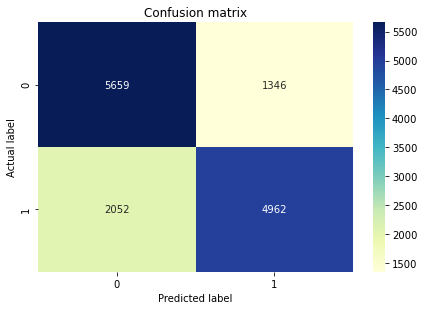

In [12]:
# use the best parameter value, 'max_depth': 10, 'criterion': 'gini', to develop tree model
best_tree=tree_cv.best_estimator_
y_pred=best_tree.predict(X_test_s)
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [13]:
print("Accuracy:",accuracy_score(y_test, y_pred).round(3))
print("Precision:",precision_score(y_test, y_pred).round(3))
print("Recall:",recall_score(y_test, y_pred).round(3))

Accuracy: 0.758
Precision: 0.787
Recall: 0.707


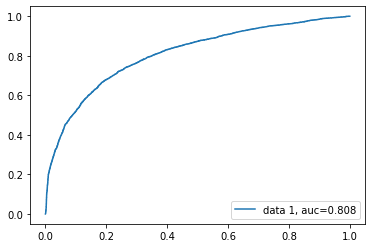

In [14]:
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(3)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

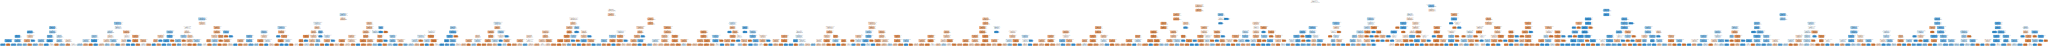

In [15]:
#Let's check the importance of features in this model
dot_data = export_graphviz(best_tree, out_file = None, feature_names = features_name, filled = True, rounded = True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

In [16]:
fea_importance=dict(zip(features_name, np.round(best_tree.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'PAY_5': 0.0, 'MARRIAGE_3': 0.0, 'PAY_6': 0.01, 'BILL_AMT2': 0.01, 'BILL_AMT3': 0.01, 'BILL_AMT4': 0.01, 'BILL_AMT5': 0.01, 'BILL_AMT6': 0.01, 'PAY_AMT3': 0.01, 'PAY_AMT5': 0.01, 'EDUCATION_4': 0.01, 'AGE': 0.02, 'PAY_3': 0.02, 'PAY_4': 0.02, 'PAY_AMT4': 0.02, 'PAY_AMT6': 0.02, 'BILL_AMT1': 0.03, 'PAY_AMT1': 0.04, 'EDUCATION_2': 0.04, 'EDUCATION_3': 0.04, 'LIMIT_BAL': 0.05, 'PAY_AMT2': 0.05, 'SEX_2': 0.07, 'MARRIAGE_2': 0.08, 'PAY_2': 0.11, 'PAY_1': 0.31}


Based on the tree plot above and feature importance attribute, we can say PAY_1, PAY_2, MARRIAGE_2, and SEX_2 are the most important features.

#### 3.1.2.3 random forest

random forest = many decison trees + many bagging. Because random forest is an ensemble of desion trees, it has all the hyperparameters of DecisionTreeClassifier and BaggingClassifers. Also as an ensemble algorithms, random forest can greatly improve the accuracy of prediction compared with a SINGLE decision tree.

We will optimize the following hyperparameters in the random forest model: 
* n_estimators = number of trees in the random forest model
* max_depth = max_depth in each decision tree

In [17]:
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depths}
start=time.time()
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_s, y_train)
end=time.time()
print("BEST PARAMS", rf_random.best_params_)
print(f"Runtime of the program is {end - start}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'n_estimators': 200, 'max_depth': 9}
Runtime of the program is 189.7614872455597


Text(0.5, 15.0, 'Predicted label')

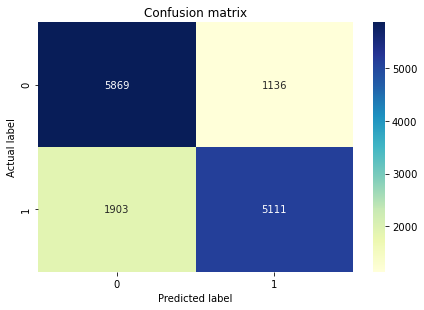

In [18]:
best_rf=rf_random.best_estimator_
y_pred=best_rf.predict(X_test_s)
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [19]:
print("Accuracy:",accuracy_score(y_test, y_pred).round(3))
print("Precision:",precision_score(y_test, y_pred).round(3))
print("Recall:",recall_score(y_test, y_pred).round(3))

Accuracy: 0.783
Precision: 0.818
Recall: 0.729


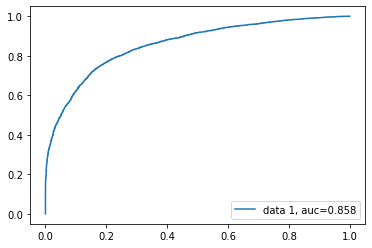

In [20]:
y_pred_proba = best_rf.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(3)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

In [21]:
fea_importance=dict(zip(features_name, np.round(best_rf.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'MARRIAGE_3': 0.0, 'EDUCATION_4': 0.0, 'AGE': 0.01, 'BILL_AMT5': 0.01, 'BILL_AMT6': 0.01, 'BILL_AMT2': 0.02, 'BILL_AMT3': 0.02, 'BILL_AMT4': 0.02, 'PAY_AMT4': 0.02, 'PAY_AMT5': 0.02, 'PAY_AMT6': 0.02, 'LIMIT_BAL': 0.03, 'PAY_5': 0.03, 'PAY_6': 0.03, 'BILL_AMT1': 0.03, 'PAY_AMT2': 0.03, 'PAY_AMT3': 0.03, 'EDUCATION_2': 0.03, 'EDUCATION_3': 0.03, 'PAY_4': 0.04, 'PAY_AMT1': 0.04, 'SEX_2': 0.06, 'PAY_3': 0.07, 'MARRIAGE_2': 0.07, 'PAY_2': 0.14, 'PAY_1': 0.18}


The top 5 important features are PAY_1, PAY_2, PAY_3, MARRIAGE_2, and SEX_2.

#### 3.1.2.4 gradient boosting

gradient boosting = decision tree + boosting. Just like random forest, [the parameters of gradient boosting](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) includes both decision tree specific parameters and boosting parameters. Compared with random forest, gradient boosting not only controls for high variance in a model, but also control the bias. Therefore, it is regarded as a more effective algorithms. The disadvantage of this algorithms is its time-consuming.

We choose three important hyperparameters to tune this model:
* learning_rate
* n_estimator
* max_depth

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
start=time.time()
param_grid = {'n_estimators': n_estimators, 'max_depth':max_depths, 'learning_rate': learning_rates}
gbm_random = RandomizedSearchCV(estimator = gbm, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
gbm_random.fit(X_train_s, y_train)
end=time.time()
print("BEST PARAMS", gbm_random.best_params_)
print(f"Runtime of the program is {end - start}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.25}
Runtime of the program is 1819.120847940445


Text(0.5, 15.0, 'Predicted label')

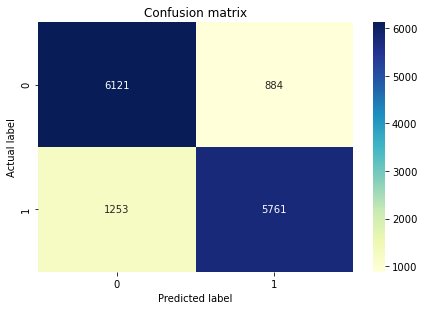

In [23]:
best_gbm=gbm_random.best_estimator_
y_pred=best_gbm.predict(X_test_s)
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [24]:
print("Accuracy:",accuracy_score(y_test, y_pred).round(3))
print("Precision:",precision_score(y_test, y_pred).round(3))
print("Recall:",recall_score(y_test, y_pred).round(3))

Accuracy: 0.848
Precision: 0.867
Recall: 0.821


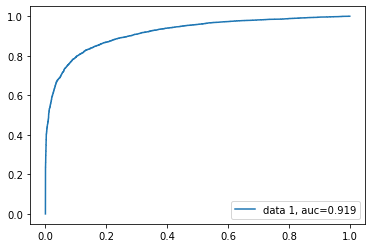

In [25]:
y_pred_proba = best_gbm.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(3)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

In [26]:
fea_importance=dict(zip(features_name, np.round(best_gbm.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'MARRIAGE_3': 0.0, 'PAY_4': 0.01, 'PAY_5': 0.01, 'PAY_6': 0.01, 'EDUCATION_4': 0.01, 'PAY_3': 0.02, 'EDUCATION_3': 0.02, 'BILL_AMT2': 0.03, 'BILL_AMT3': 0.03, 'BILL_AMT4': 0.03, 'BILL_AMT5': 0.03, 'BILL_AMT6': 0.03, 'PAY_AMT5': 0.03, 'EDUCATION_2': 0.03, 'AGE': 0.04, 'PAY_AMT3': 0.04, 'PAY_AMT4': 0.04, 'PAY_AMT6': 0.04, 'MARRIAGE_2': 0.04, 'SEX_2': 0.04, 'PAY_AMT1': 0.05, 'PAY_AMT2': 0.05, 'LIMIT_BAL': 0.06, 'BILL_AMT1': 0.06, 'PAY_2': 0.09, 'PAY_1': 0.14}


The top five important features are PAY_1, PAY_2, BILL_AMT1, LIMIT_BAL and PAY_AMT2

#### 3.1.2.5 Extreme Gradient Boosting (XGBoost)

XGBoost is short for “eXtreme Gradient Boosting.” The “eXtreme” refers to speed enhancements such as parallel computing and cache awareness that makes XGBoost approximately 10 times faster than traditional Gradient Boosting. In addition, XGBoost includes a unique split-finding algorithm to optimize trees, along with built-in regularization that reduces overfitting. Generally speaking, XGBoost is a faster, more accurate version of Gradient Boosting

In [27]:
from xgboost import XGBClassifier
xgb=XGBClassifier(use_label_encoder=False)
gammas=[0.1, 0.2, 0.3, 0.4, 0.5]
subsamples=[0.5, 0.6, 0.7, 0.8]
n_estimators=[int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
max_depths=[int(x) for x in np.linspace(1, 10, num = 10)]
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
start=time.time()
param_grid = {'gamma':gammas, 'subsample': subsamples, 'n_estimators': n_estimators, 'max_depth':max_depths, 'learning_rate': learning_rates}
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
xgb_random.fit(X_train_s, y_train)
end=time.time()
print("BEST PARAMS", xgb_random.best_params_)
print(f"Runtime of the program is {end - start}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[16:08:33] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
BEST PARAMS {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.3}
Runtime of the program is 425.85618782043457


Text(0.5, 15.0, 'Predicted label')

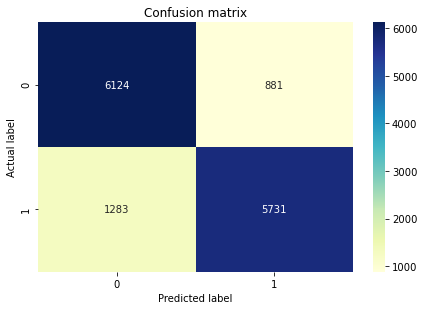

In [28]:
best_xgb=xgb_random.best_estimator_
y_pred=best_xgb.predict(X_test_s)
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [29]:
print("Accuracy:",accuracy_score(y_test, y_pred).round(3))
print("Precision:",precision_score(y_test, y_pred).round(3))
print("Recall:",recall_score(y_test, y_pred).round(3))

Accuracy: 0.846
Precision: 0.867
Recall: 0.817


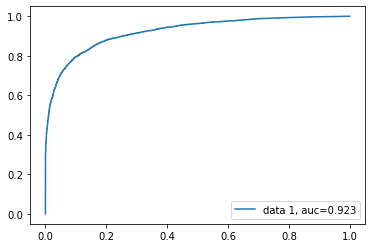

In [30]:
y_pred_proba = best_xgb.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(3)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

In [31]:
fea_importance=dict(zip(features_name, np.round(best_xgb.feature_importances_, 2)))
sort_fea_importance={}
sorted_keys = sorted(fea_importance, key=fea_importance.get)
for i in sorted_keys:
    sort_fea_importance[i]=fea_importance[i]
print(sort_fea_importance)

{'AGE': 0.01, 'BILL_AMT4': 0.01, 'BILL_AMT5': 0.01, 'BILL_AMT6': 0.01, 'PAY_AMT5': 0.01, 'LIMIT_BAL': 0.02, 'BILL_AMT1': 0.02, 'BILL_AMT2': 0.02, 'BILL_AMT3': 0.02, 'PAY_AMT1': 0.02, 'PAY_AMT2': 0.02, 'PAY_AMT3': 0.02, 'PAY_AMT4': 0.02, 'PAY_AMT6': 0.02, 'PAY_4': 0.03, 'PAY_6': 0.03, 'MARRIAGE_3': 0.03, 'PAY_3': 0.04, 'PAY_5': 0.04, 'EDUCATION_2': 0.04, 'EDUCATION_3': 0.05, 'SEX_2': 0.06, 'MARRIAGE_2': 0.07, 'EDUCATION_4': 0.07, 'PAY_1': 0.1, 'PAY_2': 0.2}


The most important features are still PAY_1, PAY_2, EDUCATION_4, MARRIAGE_2 and SEX_2.

#### 3.1.2.6 KNN

The k-nearest neighbors algorithm (KNN) is a non-parametric method used for classification. To calculate distances, 3 distance metrics that are often used are Euclidean Distance, Manhattan Distance, and Minkowski Distance. Here, we will test euclidean distance and manhattan distance.

We will tune two hyperparameters in knn, n_neighbors and p. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. 

In general practice, people choose the value of n_neighbors by calculating sqrt(N), where N stands for the number of samples in the training set.

In [32]:
n_neighbors = [50, 100, 500, 1000, 5000]
p=[1,2]
param_grid ={'n_neighbors':n_neighbors, 'p':p}
knn = KNeighborsClassifier()
start=time.time()
knn_random = RandomizedSearchCV(estimator = knn, param_distributions=param_grid, cv = 5, verbose=2, random_state=42, n_jobs = -1)
knn_random.fit(X_train_s, y_train)
end=time.time()
print("BEST PARAMS", knn_random.best_params_)
print(f"Runtime of the program is {end - start}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
BEST PARAMS {'p': 1, 'n_neighbors': 50}
Runtime of the program is 347.59017276763916


Text(0.5, 15.0, 'Predicted label')

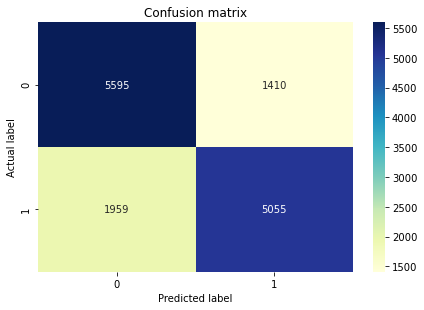

In [33]:
best_knn=knn_random.best_estimator_
y_pred=best_knn.predict(X_test_s)
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [34]:
print("Accuracy:",accuracy_score(y_test, y_pred).round(3))
print("Precision:",precision_score(y_test, y_pred).round(3))
print("Recall:",recall_score(y_test, y_pred).round(3))

Accuracy: 0.76
Precision: 0.782
Recall: 0.721


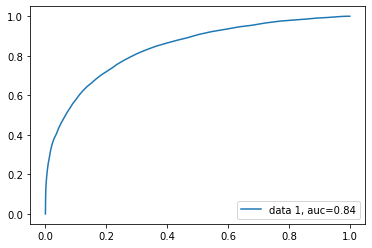

In [35]:
y_pred_proba = best_knn.predict_proba(X_test_s)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba).round(3)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

In knn algorithms, there is no available function about feature importance.But just like linear regression, we can evaluate the importance of each individual feature by performing classification using one single feature at a time. 

In [36]:
from sklearn.model_selection import cross_val_score
clf = KNeighborsClassifier(p=1, n_neighbors=50)
n_feats = X_train_s.shape[1]
print('Feature  Accuracy')
for i in range(n_feats):
    X = X_train_s[:, i].reshape(-1, 1)
    scores = cross_val_score(clf, X, y_train, cv=5)
    print(f'{i}        {scores.mean():g}')

Feature  Accuracy
0        0.623376
1        0.50295
2        0.663609
3        0.647008
4        0.6065
5        0.59207
6        0.580941
7        0.580452
8        0.530435
9        0.535052
10        0.53389
11        0.533034
12        0.542083
13        0.538629
14        0.616588
15        0.614785
16        0.61882
17        0.606102
18        0.611116
19        0.616405
20        0.520682
21        0.500871
22        0.522608
23        0.511816
24        0.507964
25        0.501513


In [43]:
print(features_name[0], features_name[2:4], features_name[18:20])

LIMIT_BAL Index(['PAY_1', 'PAY_2'], dtype='object') Index(['PAY_AMT5', 'PAY_AMT6'], dtype='object')


Well, it seems feature 0, 2, 3, 18, 19 are more important than the other predictors. They are corresponding to LIMIT_BAL, PAY_1, PAY_2, PAY_AMT5 and PAY_AMT6

### 3.3 summary

Text(0.5, 1.0, 'the ROC/AUC curves of all studied models')

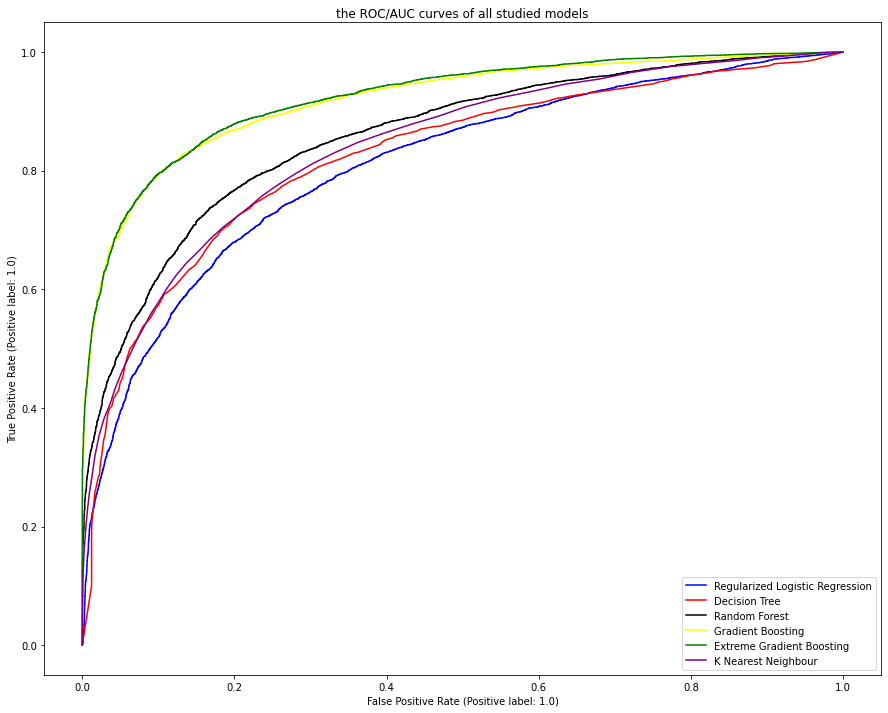

In [37]:
from sklearn.metrics import plot_roc_curve
fig,ax=plt.subplots(figsize=(15,12))
plot_roc_curve(best_C_logreg, X_test_s, y_test,ax=ax, color="blue",label='Regularized Logistic Regression')
plot_roc_curve(best_tree, X_test_s, y_test,ax=ax, color="red",label='Decision Tree')
plot_roc_curve(best_rf, X_test_s, y_test,ax=ax, color="black",label='Random Forest')
plot_roc_curve(best_gbm, X_test_s, y_test,ax=ax, color="yellow",label='Gradient Boosting')
plot_roc_curve(best_xgb, X_test_s, y_test,ax=ax, color="green",label='Extreme Gradient Boosting')
plot_roc_curve(best_knn, X_test_s, y_test,ax=ax, color="purple",label='K Nearest Neighbour')
plt.title('the ROC/AUC curves of all studied models')

XGB and gradient boosting gave us the best results, followed by random forest. The logistic regression is the worst among all these 6 algorithms

Although different algorithms gave us slightly difference sequence of feature importance, PAY_1, PAY_2 and PAY_3 are consistently the most important ones.

In the next section, we will develop a machine learning pipline to help us better optimize and select algorithms. We will also explore the reduced dataset df_sum to develop the prediction model for credit card default.